# ensemble: classifier + FAISS

In [1]:
import pandas as pd

input_path = "~/p-dsgt_clef2025-0/shared/plantclef/submissions"
# knn
knn_folder = "knn/topk_10/grid_4/topk_10_grid_4_p_0.1_per_image"
knn_file_name = "dsgt_run_topk_10_grid_4_p_0.1_per_image.csv"
# classifier
clf_folder = "topk_10_species_grid_4x4"
clf_file_name = f"dsgt_run_{clf_folder}.csv"
# read CSV file
knn_df = pd.read_csv(f"{input_path}/{knn_folder}/{knn_file_name}", delimiter=";")
clf_df = pd.read_csv(f"{input_path}/{clf_folder}/{clf_file_name}", delimiter=";")

display(knn_df.head())
display(clf_df.head())

,plot_id,species_ids
0,CBN-PdlC-A1-20130807,"[1418612, 1392611, 1390793, 1396733, 1392608, ..."
1,CBN-PdlC-A1-20130903,"[1412857, 1396733, 1394311, 1390793, 1395944]"
2,CBN-PdlC-A1-20140721,"[1412857, 1651363, 1390793, 1418612, 1391499, ..."
3,CBN-PdlC-A1-20140811,"[1396408, 1390846, 1742052, 1412857, 1390793, ..."
4,CBN-PdlC-A1-20140901,"[1395974, 1390793, 1396733, 1394671, 1395944, ..."


,plot_id,species_ids
0,CBN-PdlC-A1-20130807,"[1392407, 1392608, 1392611, 1395807, 1741624, ..."
1,CBN-PdlC-A1-20130903,"[1395807, 1742052, 1362271, 1412857, 1397535, ..."
2,CBN-PdlC-A1-20140721,"[1412857, 1395807, 1396144, 1397535, 1392608, ..."
3,CBN-PdlC-A1-20140811,"[1395807, 1412857, 1392608, 1519650]"
4,CBN-PdlC-A1-20140901,"[1361281, 1392608, 1742052, 1412857, 1391331]"


In [2]:
knn_df.count(), clf_df.count()

(plot_id        1695
 species_ids    1695
 dtype: int64,
 plot_id        1695
 species_ids    1695
 dtype: int64)

### union & inner join

In [3]:
# union function
def union_species_ids(knn_df, clf_df):
    merged_df = knn_df.merge(
        clf_df, on="plot_id", how="outer", suffixes=("_knn", "_clf")
    )
    merged_df["species_ids"] = merged_df.apply(
        lambda row: list(
            set(
                eval(row["species_ids_knn"]) if pd.notna(row["species_ids_knn"]) else []
            )
            | set(
                eval(row["species_ids_clf"]) if pd.notna(row["species_ids_clf"]) else []
            )
        ),
        axis=1,
    )
    return merged_df[["plot_id", "species_ids"]]


# inner join function
def inner_join_species_ids(knn_df, clf_df):
    merged_df = knn_df.merge(
        clf_df, on="plot_id", how="inner", suffixes=("_knn", "_clf")
    )
    merged_df["species_ids"] = merged_df.apply(
        lambda row: list(
            set(eval(row["species_ids_knn"])) & set(eval(row["species_ids_clf"]))
        ),
        axis=1,
    )
    return merged_df[["plot_id", "species_ids"]]

In [ ]:
union_df = union_species_ids(knn_df, clf_df)
inner_join_df = inner_join_species_ids(knn_df, clf_df)

display(union_df.head())
display(inner_join_df.head())

,plot_id,species_ids
0,CBN-PdlC-A1-20130807,"[1392608, 1392611, 1362471, 1390793, 1418612, ..."
1,CBN-PdlC-A1-20130903,"[1392608, 1742052, 1394311, 1395944, 1390793, ..."
2,CBN-PdlC-A1-20140721,"[1392608, 1651363, 1395944, 1390793, 1391499, ..."
3,CBN-PdlC-A1-20140811,"[1392608, 1519650, 1742052, 1390793, 1396408, ..."
4,CBN-PdlC-A1-20140901,"[1392608, 1361281, 1391331, 1742052, 1395974, ..."


,plot_id,species_ids
0,CBN-PdlC-A1-20130807,"[1392608, 1392611]"
1,CBN-PdlC-A1-20130903,[1412857]
2,CBN-PdlC-A1-20140721,[1412857]
3,CBN-PdlC-A1-20140811,[1412857]
4,CBN-PdlC-A1-20140901,[]


### jaccard similarity

In [5]:
# define Jaccard similarity-based ensemble function
def jaccard_ensemble(knn_df, clf_df, threshold=0.5):
    merged_df = knn_df.merge(
        clf_df, on="plot_id", how="outer", suffixes=("_knn", "_clf")
    )

    def compute_jaccard(row):
        species_knn = (
            set(eval(row["species_ids_knn"]))
            if pd.notna(row["species_ids_knn"])
            else set()
        )
        species_clf = (
            set(eval(row["species_ids_clf"]))
            if pd.notna(row["species_ids_clf"])
            else set()
        )

        if not species_knn or not species_clf:
            return list(species_knn | species_clf)  # if one is empty, return the other

        intersection = species_knn & species_clf
        union = species_knn | species_clf
        jaccard_similarity = len(intersection) / len(union) if len(union) > 0 else 0

        if jaccard_similarity >= threshold:
            return list(union)  # high similarity -> use union
        else:
            return (
                list(intersection) if intersection else list(species_knn)
            )  # low similarity -> use intersection

    merged_df["species_ids"] = merged_df.apply(compute_jaccard, axis=1)
    return merged_df[["plot_id", "species_ids"]]

In [6]:
# apply Jaccard similarity-based ensemble function
threshold = 0.5
jaccard_df = jaccard_ensemble(knn_df, clf_df, threshold)
display(jaccard_df.head(10))

,plot_id,species_ids
0,CBN-PdlC-A1-20130807,"[1392608, 1392611]"
1,CBN-PdlC-A1-20130903,[1412857]
2,CBN-PdlC-A1-20140721,[1412857]
3,CBN-PdlC-A1-20140811,[1412857]
4,CBN-PdlC-A1-20140901,"[1395974, 1395944, 1390793, 1394671, 1396733, ..."
5,CBN-PdlC-A1-20150701,[1741880]
6,CBN-PdlC-A1-20150720,[1412857]
7,CBN-PdlC-A1-20150831,"[1412857, 1392611, 1742052]"
8,CBN-PdlC-A1-20160705,[1392611]
9,CBN-PdlC-A1-20160726,[1549015]


In [17]:
threshold = 0.2
jaccard_df = jaccard_ensemble(knn_df, clf_df, threshold)
display(jaccard_df.head(10))

,plot_id,species_ids
0,CBN-PdlC-A1-20130807,"[1392608, 1392611]"
1,CBN-PdlC-A1-20130903,[1412857]
2,CBN-PdlC-A1-20140721,[1412857]
3,CBN-PdlC-A1-20140811,[1412857]
4,CBN-PdlC-A1-20140901,"[1395974, 1395944, 1390793, 1394671, 1396733, ..."
5,CBN-PdlC-A1-20150701,[1741880]
6,CBN-PdlC-A1-20150720,[1412857]
7,CBN-PdlC-A1-20150831,"[1392608, 1519650, 1392611, 1742052, 1390793, ..."
8,CBN-PdlC-A1-20160705,[1392611]
9,CBN-PdlC-A1-20160726,[1549015]


In [8]:
def compute_jaccard_coefficient(knn_df, clf_df):
    merged_df = knn_df.merge(
        clf_df, on="plot_id", how="outer", suffixes=("_knn", "_clf")
    )

    jaccard_scores = []
    for _, row in merged_df.iterrows():
        species_knn = (
            set(eval(row["species_ids_knn"]))
            if pd.notna(row["species_ids_knn"])
            else set()
        )
        species_clf = (
            set(eval(row["species_ids_clf"]))
            if pd.notna(row["species_ids_clf"])
            else set()
        )

        intersection = species_knn & species_clf
        union = species_knn | species_clf
        jaccard_similarity = len(intersection) / len(union) if len(union) > 0 else 0
        jaccard_scores.append(jaccard_similarity)

    return jaccard_scores


def jaccard_stats(knn_df, clf_df, thresholds):
    jaccard_scores = compute_jaccard_coefficient(knn_df, clf_df)

    stats = []
    for threshold in thresholds:
        filtered_scores = [score for score in jaccard_scores if score >= threshold]
        avg_jaccard = (
            sum(filtered_scores) / len(filtered_scores) if filtered_scores else 0
        )
        stats.append((threshold, avg_jaccard))

    return pd.DataFrame(stats, columns=["threshold", "avg_jaccard"])

In [9]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
jaccard_stats = jaccard_stats(knn_df, clf_df, thresholds)
jaccard_stats.head(10)

,threshold,avg_jaccard
0,0.1,0.232817
1,0.2,0.321591
2,0.3,0.438117
3,0.4,0.518322
4,0.5,0.587793
5,0.6,0.770513
6,0.7,0.936364
7,0.8,0.977778
8,0.9,1.000000


In [10]:
import matplotlib.pyplot as plt


# plot Jaccard statistics
def plot_jaccard_statistics(jaccard_df, title: str, y_label: str):
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    fig.suptitle(
        title,
        weight="bold",
        fontsize=14,
    )
    cols = jaccard_df.columns
    ax.plot(
        jaccard_df[cols[0]],
        jaccard_df[cols[1]],
        marker="o",
        markersize=8,
        linestyle="-",
        linewidth=3,
    )
    ax.set_xlabel("Jaccard Similarity Threshold", fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    ax.grid(color="blue", linestyle="--", linewidth=1, alpha=0.2)
    for s in ["top", "right", "bottom", "left"]:
        ax.spines[s].set_visible(False)
    plt.tight_layout()
    plt.show()

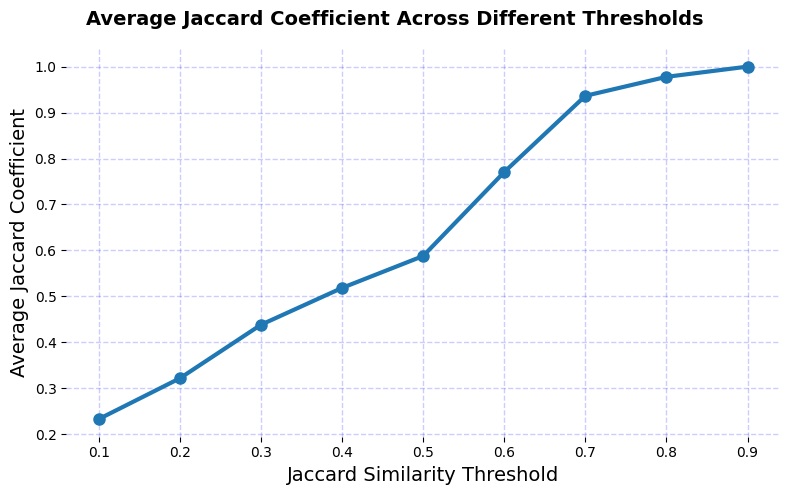

In [11]:
title = "Average Jaccard Coefficient Across Different Thresholds"
y_label = "Average Jaccard Coefficient"
plot_jaccard_statistics(jaccard_stats, title, y_label)

In [ ]:
# compute number of distinct species in the merged dataframe for different thresholds
def distinct_species_by_threshold(knn_df, clf_df, thresholds):
    results = []

    for threshold in thresholds:
        merged_df = knn_df.merge(
            clf_df, on="plot_id", how="outer", suffixes=("_knn", "_clf")
        )

        def compute_species(row):
            species_knn = (
                set(eval(row["species_ids_knn"]))
                if pd.notna(row["species_ids_knn"])
                else set()
            )
            species_clf = (
                set(eval(row["species_ids_clf"]))
                if pd.notna(row["species_ids_clf"])
                else set()
            )

            if not species_knn or not species_clf:
                return species_knn | species_clf  # if one is empty, return the other

            intersection = species_knn & species_clf
            union = species_knn | species_clf
            jaccard_similarity = len(intersection) / len(union) if len(union) > 0 else 0

            if jaccard_similarity >= threshold:
                return union  # high similarity -> use union
            else:
                return (
                    intersection if intersection else species_knn
                )  # low similarity -> use intersection

        merged_df["species_ids"] = merged_df.apply(compute_species, axis=1)

        # count the number of distinct species across all plots
        all_species = set()
        merged_df["species_ids"].apply(lambda x: all_species.update(x))
        results.append((threshold, len(all_species)))

    return pd.DataFrame(results, columns=["threshold", "num_species"])

In [13]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
jaccard_species_count = distinct_species_by_threshold(knn_df, clf_df, thresholds)
jaccard_species_count.head(10)

,threshold,num_species
0,0.1,971
1,0.2,749
2,0.3,592
3,0.4,512
4,0.5,468
5,0.6,449
6,0.7,446
7,0.8,445
8,0.9,445


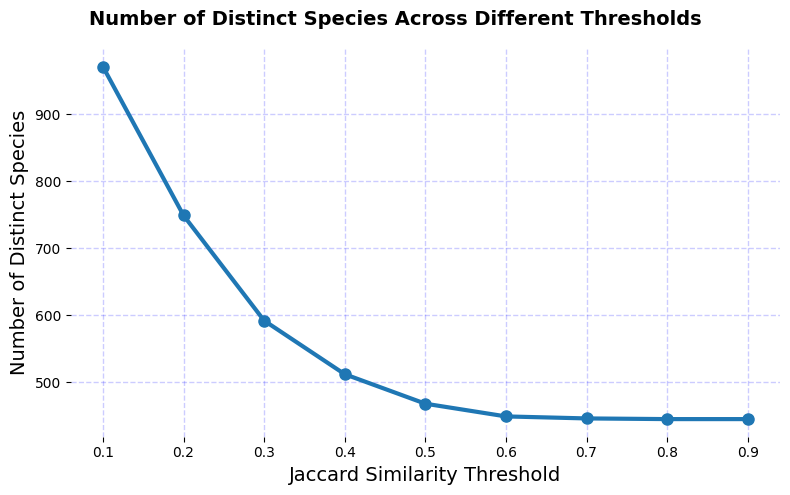

In [14]:
title = "Number of Distinct Species Across Different Thresholds"
y_label = "Number of Distinct Species"
plot_jaccard_statistics(jaccard_species_count, title, y_label)

### submit results

In [19]:
import os
import csv
from pathlib import Path


def format_species_ids(species_ids: list) -> str:
    """Formats the species IDs in single square brackets, separated by commas."""
    formatted_ids = ", ".join(str(id) for id in species_ids)
    return f"[{formatted_ids}]"


def prepare_and_write_submission(pandas_df: pd.DataFrame) -> pd.DataFrame:
    """Converts Spark DataFrame to Pandas, formats it, and writes to GCS."""
    records = []
    for _, row in pandas_df.iterrows():
        logits = row["species_ids"]
        formatted_species = format_species_ids(logits)
        records.append({"plot_id": row["plot_id"], "species_ids": formatted_species})

    pandas_df = pd.DataFrame(records)
    return pandas_df


def get_plantclef_dir() -> str:
    home_dir = Path(os.path.expanduser("~"))
    return f"{home_dir}/p-dsgt_clef2025-0/shared/plantclef"


def write_csv_to_pace(df, file_name: str):
    """Writes the Pandas DataFrame to a CSV file in GCS."""

    # prepare and write the submission
    submission_df = prepare_and_write_submission(df)
    project_dir = get_plantclef_dir()
    submission_path = f"{project_dir}/submissions/ensemble"
    output_path = f"{submission_path}/{file_name}"
    # ensure directory exists before saving
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    # write to CSV
    submission_df.to_csv(output_path, sep=";", index=False, quoting=csv.QUOTE_NONE)
    print(f"Submission file saved to: {output_path}")

In [20]:
# prepare and write the submission
FILE_NAME = "ensemble_top10_grid4x4.csv"
sub_file_name = f"union_{FILE_NAME}"
write_csv_to_pace(union_df, sub_file_name)

Submission file saved to: /storage/home/hcoda1/9/mgustineli3/p-dsgt_clef2025-0/shared/plantclef/submissions/ensemble/union_ensemble_top10_grid4x4.csv


In [21]:
# prepare and write the submission
FILE_NAME = "ensemble_top10_grid4x4.csv"
sub_file_name = f"jac_thr0.2_{FILE_NAME}"
write_csv_to_pace(jaccard_df, sub_file_name)

Submission file saved to: /storage/home/hcoda1/9/mgustineli3/p-dsgt_clef2025-0/shared/plantclef/submissions/ensemble/jac_thr0.2_ensemble_top10_grid4x4.csv
